In [18]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from common import create_engine, display_all

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # converters e.g. for datetime in plots

In [19]:
engine = create_engine('db-conf.json', 'dp.kamko.dev')
pd.sql = lambda sql: pd.read_sql(sql, con=engine)

Najnovsie info o facebook engagemente pre sledovane URL

In [31]:
df = pd.sql('''
SELECT sq.*, s.url as source
FROM (
         SELECT afb.*, row_number() over (partition by url order by sync_date desc) rn
         FROM article_fb_engagement afb) sq
JOIN article a on sq.url = a.url
JOIN source s on a.source_id = s.id
WHERE sq.rn = 1;
''')
df['popularity'] = df['reaction_count'] + df['comment_count'] + df['share_count']

In [4]:
display_all(df.groupby('source')['popularity'].describe().sort_values('count', ascending=False))

,count,mean,std,min,25%,50%,75%,max
source,,,,,,,,
http://naturalnews.com,20945.0,1225.714825,41313.845801,0.0,19.00,88.0,250.00,5197586.0
http://naturalnewsblogs.com,17756.0,86.888263,2294.673255,0.0,0.00,0.0,1.00,203855.0
http://neurosciencenews.com,13148.0,271.558564,4006.532868,0.0,0.00,0.0,45.25,294411.0
http://statnews.com,12275.0,211.472505,1868.624163,0.0,0.00,0.0,23.00,82773.0
http://hsionline.com,8175.0,0.821162,12.145379,0.0,0.00,0.0,0.00,726.0
http://naturalsociety.com,7350.0,10.235374,598.635593,0.0,0.00,0.0,0.00,49319.0
http://healthnutnews.com,7249.0,1657.439095,23514.407619,0.0,4.00,179.0,741.00,1810343.0
http://healthimpactnews.com,6267.0,354.368917,10890.051283,0.0,0.00,0.0,9.00,841807.0
http://infowars.com,6024.0,52.932105,380.116241,0.0,0.00,0.0,8.00,16902.0


In [5]:
def show_source_popularity_histogram(df, source, quantile):
    xdf = df[df['source'] == source]
    xdf = xdf[xdf['popularity'] < xdf['popularity'].quantile(quantile)]
    plot = sns.distplot(xdf['popularity'])
    plt.show()
    return plot

sources_sorted = df.groupby('source')['popularity'].describe().sort_values('count', ascending=False).index

In [21]:
rsc = df[['url', 'reaction_count', 'share_count', 'comment_count']]

In [22]:
rsc.corr()

,reaction_count,share_count,comment_count
reaction_count,1.000000,0.883919,0.762407
share_count,0.883919,1.000000,0.861535
comment_count,0.762407,0.861535,1.000000


Normalizovana popularita voci casu (x = 0 == datum najskorsieho clanku)

In [111]:
monitored_articles = pd.sql('''
SELECT afe.*, art.published_at
FROM article_fb_engagement afe
         JOIN article art on afe.url = art.url
WHERE afe.url in (SELECT url
                  FROM article
                           JOIN monitored_article ma on article.id = ma.article_id)
  AND art.published_at > (SELECT min(mjrl.run_finished) FROM monitor_job_run_log mjrl)
ORDER BY afe.url, sync_date;
''')

monitored_articles.sync_date = monitored_articles.sync_date + pd.DateOffset(hours=2) # sync_date is in UTC and published_at is in UTC+2 (I hope)
monitored_articles = monitored_articles.drop(columns=['comment_plugin_count', 'id'])
monitored_articles['popularity'] = monitored_articles['reaction_count'] + monitored_articles['comment_count'] + monitored_articles['share_count']

In [172]:
# add artifical first row for every value where engagement = (0,0,0) and sync_date = published_at
_mart = monitored_articles
_mart = _mart.sort_values(by=['url', 'sync_date'])
_mart = _mart.groupby('url').first().reset_index()
_mart = _mart.drop_duplicates()

first_rows = []
for row in _mart.itertuples():
    first_rows.append([row.url, 0, 0, 0, row.published_at, row.published_at, 0, False])
    first_rows.append([row.url, row.reaction_count, row.comment_count, row.share_count, row.sync_date, row.published_at, row.popularity, False])
    
monitored_articles_art = monitored_articles.copy()
monitored_articles_art['real_observation'] = True
monitored_articles_art = pd.concat([monitored_articles_art, pd.DataFrame(first_rows, columns=monitored_articles_art.columns)], ignore_index=True)
monitored_articles_art = monitored_articles_art.sort_values(by=['url', 'sync_date', 'real_observation'])

In [173]:
monitored_articles_art.head()

,url,reaction_count,comment_count,share_count,sync_date,published_at,popularity,real_observation
374747,http://blog.healthadvocate.com/2019/10/four-fo...,0,0,0,2019-10-25 04:42:00.000000,2019-10-25 04:42:00,0,0
374748,http://blog.healthadvocate.com/2019/10/four-fo...,0,0,0,2019-10-25 19:06:19.449111,2019-10-25 04:42:00,0,0
0,http://blog.healthadvocate.com/2019/10/four-fo...,0,0,0,2019-10-25 19:06:19.449111,2019-10-25 04:42:00,0,1
1,http://blog.healthadvocate.com/2019/10/four-fo...,0,0,0,2019-10-25 21:06:30.132140,2019-10-25 04:42:00,0,1
2,http://blog.healthadvocate.com/2019/10/four-fo...,0,0,0,2019-10-25 23:06:40.932503,2019-10-25 04:42:00,0,1


In [189]:
def sample_articles(data, size, random_state=None):
    urls = pd.Series(monitored_articles_art.url.unique()).sample(n=size, random_state=random_state)
    return monitored_articles_art[monitored_articles_art.url.isin(urls)].copy()

def plot_engagement(data, extra_plt_args=None):
    if extra_plt_args is None:
        extra_plt_args = {}

    min_time = data['sync_date'].min()
    rplot = sns.relplot(data=data,
                x='sync_date', y='popularity',
                hue='url', style='real_observation', style_order=[True, False],
                kind='line', height=12, aspect=1,
                legend=False)
    rplot.set(xlim=(min_time, None))
    rplot.set(**extra_plt_args)
    return rplot

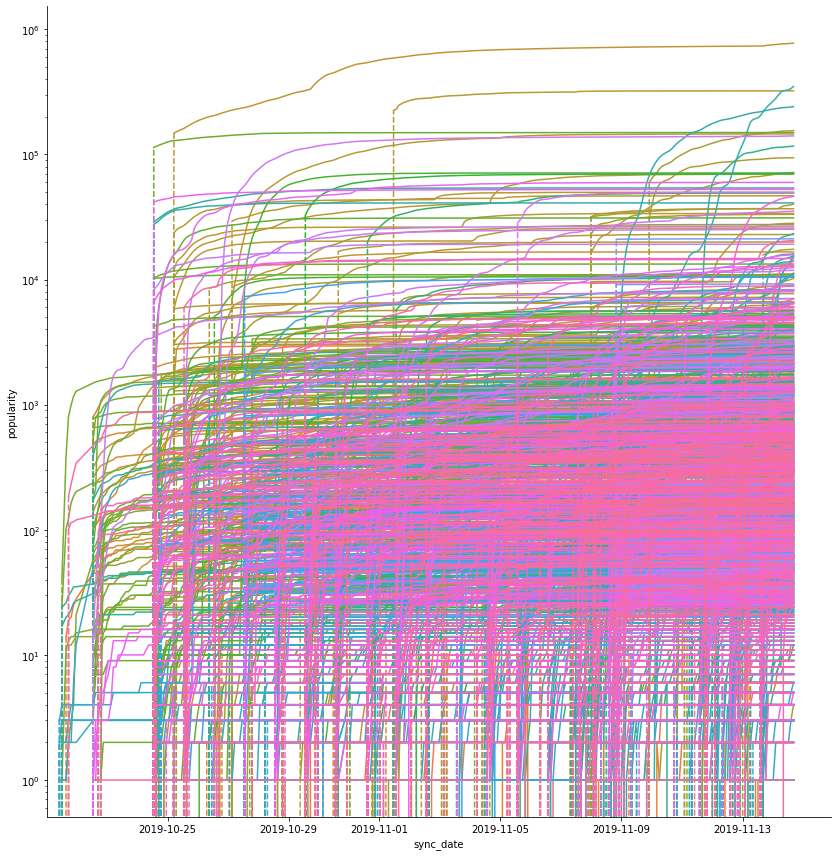

In [234]:
sampled_articles = sample_articles(data=monitored_articles_art, size=2000, random_state=12345)
plot_engagement(sampled_articles, extra_plt_args={'yscale' : 'log'})